# Experiments

**MovieLens 25M dataset subsamples**

We have 6 subsamples (see subsample_creation.ipynb and Dataset chapter in the article). 2 are large, 2 are medium, 2 are small. Of each pair, one has higher level of data pruning, and the other has lower resulting in higher sparsity and lower sparsity.

**Models**

We compare the performance of these models for the top-N recommendation task:
- LightGCN
- model 2

**Metrics**

As performance metrics we use:
- Recall@K
- Precision@K
- NDCG@K

We use K = [10, 20, 50, 100] to see if different K-s influence the ranking

## Import libraries

In [1]:
# Import torch

import torch
from torch import Tensor
print(torch.__version__)

2.0.1


In [2]:
# Import libraries
import os
import timeit
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torch import nn, optim
from torch_sparse import SparseTensor, matmul
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

from graph import *
from lightgcn import *

## Load movie data

In [3]:
# Read in the movies data
movies_path = './data/movie_ml_imdb.csv'
movies = pd.read_csv(movies_path, sep='\t')

# Keep only the columns of interest to us
movies = movies[['movieId', 'title', 'genres_ml', 'year', 'actor', 'actress', 'director', 'producer', 'writer']]

# Replace \N
movies = movies.replace(r'\\N',  'Unknown', regex=True)

# Rename genres
movies = movies.rename(columns={"genres_ml": "genre"})

In [4]:
movies.head()

,movieId,title,genre,year,actor,actress,director,producer,writer
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,nm0000158|nm0000741|nm0725543|nm0001815,Unknown,nm0005124,Unknown,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736
1,2,Jumanji,Adventure|Children|Fantasy,1995,nm0000245|nm0404993,nm0000379|nm0001372,nm0002653,nm0472256,nm0378144|nm0852430|nm0833164|nm0885575
2,3,Grumpier Old Men,Comedy|Romance,1995,nm0000527|nm0000493,nm0000268|nm0000047,nm0222043,nm0075828|nm0204862,nm0425756
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995,Unknown,nm0001365|nm0000291|nm0222643|nm0005375,nm0001845,nm0771834|nm0842470,nm0573334|nm0060103
4,5,Father of the Bride Part II,Comedy,1995,nm0000188|nm0001737,nm0000473|nm0931090,nm0796124,Unknown,nm0352443|nm0329304|nm0583600


## Experiments

In [5]:
# We experiment with 6 subsamples of different size and levels of sparsity
datasets = ['1_subsample_2018_2019_nopruning.csv',
            '2_subsample_2018_2019_pruned.csv',
            '3_subsample_2018_2019_5000_users.csv',
            '4_subsample_2018_2019_5000_users_pruned.csv',
            '5_subsample_2018_2019_1000_users.csv',
            '6_subsample_2018_2019_1000_users_pruned.csv']

# We experiment with 3 different split strategies
split_strategies = ['random','leave_one_out','temporal']

In [6]:
# Ensure it works first

datasets = ['6_subsample_2018_2019_1000_users_pruned.csv']
split_strategies = ['random', 'temporal']

In [7]:
# define contants for the LightGCN model
ITERATIONS = 10000
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = [10, 20, 50, 100]
LAMBDA = 1e-6

In [8]:
all_train_losses = []
all_val_losses = []
all_test_losses = []
all_recalls = []
all_precisions = []
all_ndcgs = []
elapsed_times = []

# We have 6x3=18 experiments in total
for dataset_file in datasets:
    for split_strategy in split_strategies:

        print(f'Starting a new experiment with {dataset_file} and split strategy {split_strategy}')
        starttime = timeit.default_timer()

        print('Reading in the subsample ...')
        # Read in the subsample
        rating_path = f'./data/{dataset_file}'
        ratings = pd.read_csv(rating_path)

        print('Loading nodes...')
        # Load user nodes
        user_x, user_mapping = load_nodes(ratings, index_col='userId')

        # Keep only movies that are in the subsample
        movies_in_ratings = ratings.movieId.unique()
        movies_in_this_subsample = movies[movies.movieId.isin(movies_in_ratings)]

        # Load movie (item) nodes
        movie_x, movie_mapping = load_nodes(movies_in_this_subsample,
                                    index_col='movieId',
                                    encoders={'title': SequenceEncoder(), # Teeme kõik movie node feature-iteks. Alternatiiv oleks need teha eraldi node-ideks
                                              'genre': CategoryEncoder(),
                                              'year': CategoryEncoder(),
                                              'actor': CategoryEncoder(),
                                              'actress': CategoryEncoder(),
                                              'director': CategoryEncoder(),
                                              'producer': CategoryEncoder(),
                                              'writer': CategoryEncoder()})
        
        print('Loading edges...')
        # Load edges
        edge_index, edge_attr, edge_timestamp = load_edges(ratings,
                                                           src_index_col='userId',
                                                           src_mapping=user_mapping,
                                                           dst_index_col='movieId',
                                                           dst_mapping=movie_mapping
                                                           )
        
        num_users, num_movies = len(user_mapping), len(movie_mapping)
        print('Users in total: ', num_users)
        print('Movies in total: ', num_movies)

        print('Train-test split...')
        # Split the edges according to the split strategy
        train_edge_index, val_edge_index, test_edge_index = train_val_test_split(edge_index, split_strategy)

        num_edges_in_train = train_edge_index.shape[1]
        num_edges_in_val = val_edge_index.shape[1]
        num_edges_in_test = test_edge_index.shape[1]

        print('Num edges in training set: ', num_edges_in_train)
        print('Num edges in validation set: ', num_edges_in_val)
        print('Num edges in test set: ', num_edges_in_test)

        # Convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
        train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(
            num_users + num_movies, num_users + num_movies))
        val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(
            num_users + num_movies, num_users + num_movies))
        test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(
            num_users + num_movies, num_users + num_movies))
        

        # The model
        model = LightGCN(num_users, num_movies)
        
        # Setup
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device {device}.")

        model = model.to(device)
        model.train()

        optimizer = optim.Adam(model.parameters(), lr=LR)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

        edge_index = edge_index.to(device)
        train_edge_index = train_edge_index.to(device)
        train_sparse_edge_index = train_sparse_edge_index.to(device)

        val_edge_index = val_edge_index.to(device)
        val_sparse_edge_index = val_sparse_edge_index.to(device)

        # training loop
        train_losses = []
        val_losses = []

        for iter in range(ITERATIONS):
            # forward propagation
            users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
                train_sparse_edge_index)

            # mini batching
            user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
                BATCH_SIZE, train_edge_index)
            user_indices, pos_item_indices, neg_item_indices = user_indices.to(
                device), pos_item_indices.to(device), neg_item_indices.to(device)
            users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
            pos_items_emb_final, pos_items_emb_0 = items_emb_final[
                pos_item_indices], items_emb_0[pos_item_indices]
            neg_items_emb_final, neg_items_emb_0 = items_emb_final[
                neg_item_indices], items_emb_0[neg_item_indices]

            # loss computation
            train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                                pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            if iter % ITERS_PER_EVAL == 0:
                model.eval()
                print(f"[Iteration {iter}/{ITERATIONS}]")
                print('Train loss: ', train_loss)
                print('Validation:')
                val_loss, recall, precision, ndcg = evaluation(
                    model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
                train_losses.append(train_loss.item())
                val_losses.append(val_loss)
                model.train()

            if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
                scheduler.step()

        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        print('Evaluating...')
        # evaluate on test set
        model.eval()
        test_edge_index = test_edge_index.to(device)
        test_sparse_edge_index = test_sparse_edge_index.to(device)

        print('Performance on test set:')
        test_loss, test_recall, test_precision, test_ndcg = evaluation(
                    model, test_edge_index, test_sparse_edge_index, [train_edge_index, val_edge_index], K, LAMBDA)

        all_test_losses.append(test_loss)
        all_recalls.append(test_recall)
        all_precisions.append(test_precision)
        all_ndcgs.append(test_ndcg)

        print('DONE!')
        time_elapsed = timeit.default_timer() - starttime
        print("Time elapsed :", time_elapsed)
        elapsed_times.append(time_elapsed)
        print()

Starting a new experiment with 6_subsample_2018_2019_1000_users_pruned.csv and split strategy random
Reading in the subsample ...
Loading nodes...


Batches:   0%|          | 0/68 [00:00<?, ?it/s]

Loading edges...
Users in total:  909
Movies in total:  2146
Train-test split...
Num edges in training set:  79892
Num edges in validation set:  9987
Num edges in test set:  9987
Using device cpu.
[Iteration 0/10000]
Train loss:  tensor(-0.6910, grad_fn=<AddBackward0>)
Validation:
Loss:  -0.6739947199821472
[recall@10: 0.00522, precision@10: 0.00645, ndcg@10: 0.00692
[recall@20: 0.01101, precision@20: 0.00526, ndcg@20: 0.00824
[recall@50: 0.02826, precision@50: 0.00593, ndcg@50: 0.01425
[recall@100: 0.05044, precision@100: 0.00607, ndcg@100: 0.02187
[Iteration 200/10000]
Train loss:  tensor(-0.7045, grad_fn=<AddBackward0>)
Validation:
Loss:  -0.6841495037078857
[recall@10: 0.04495, precision@10: 0.04378, ndcg@10: 0.05417
[recall@20: 0.07981, precision@20: 0.03869, ndcg@20: 0.06342
[recall@50: 0.15074, precision@50: 0.03084, ndcg@50: 0.08681
[recall@100: 0.26552, precision@100: 0.02654, ndcg@100: 0.1211
[Iteration 400/10000]
Train loss:  tensor(-1.0714, grad_fn=<AddBackward0>)
Validatio

# Plot training and validation loss curves

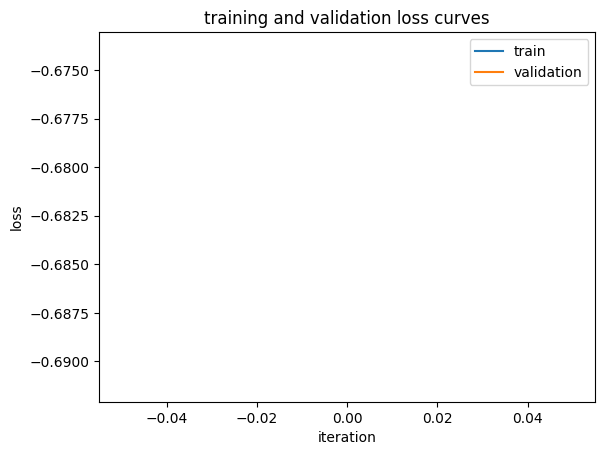

In [ ]:
# Only the first model here
train_losses = all_train_losses[0]
val_losses = all_val_losses[0]
    
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

## Analyze results

In [ ]:
all_recalls

[{100: 0.07229554653167725}, {100: 0.0460338294506073}]

In [ ]:
all_precisions

[{100: 0.0075767915695905685}, {100: 0.018951965495944023}]

In [ ]:
all_ndcgs

[{100: 0.029049761593341827}, {100: 0.032727740705013275}]

In [ ]:
elapsed_times

[162.66119229997275, 190.50661369995214]

## References

Our code is inspired by these tutorials:
- https://colab.research.google.com/drive/1VfP6JlWbX_AJnx88yN1tM3BYE6XAADiy?usp=sharing 
- https://colab.research.google.com/drive/1KKugoFyUdydYC0XRyddcROzfQdMwDcnO?usp=sharing&fbclid=IwAR1-1pncUhTk5HZ8tP74e6thaK2gBaTD0FX7uqABTzE_-OLSLpSaUBOq0mA
- https://colab.research.google.com/drive/1xpzn1Nvai1ygd_P5Yambc_oe4VBPK_ZT?usp=sharing&fbclid=IwAR1jsKGQhpdRrM22Fgg5ljTa4x1c4epqlTPsgou_2mIo6rBmjnLY1q8TmMU#scrollTo=D6ixkcCOwCDi
- https://github.com/gusye1234/LightGCN-PyTorch
- https://www.kaggle.com/dipanjandas96/lightgcn-pytorch-from-scratch
- https://pytorch-geometric.readthedocs.io/en/latest/notes/load_csv.html